In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel

/home/miotto/miniconda3/envs/transformers/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True, output_attentions=True)
model.eval()

print("Model name:", model.config.name_or_path)
print("Tokenizer:", tokenizer.name_or_path)
print("Vocabulary size:", tokenizer.vocab_size)
print("Embedding dimensions:", model.config.hidden_size)
print("Number of attention layers:", model.config.num_hidden_layers)

Model name: gpt2
Tokenizer: gpt2
Vocabulary size: 50257
Embedding dimensions: 768
Number of attention layers: 12


In [3]:
embeddings = model.wte.weight.data
print("Vocabulary size: K =", embeddings.shape[0])
print("Embedding size:  D =", embeddings.shape[1], '\n')

input_text = "The american flag is red, white and blue"
inputs = tokenizer(input_text, return_tensors="pt")

print(f"Input text: '{input_text}'")
print(f"\nBUFFER TOKENS (N = {inputs["input_ids"][0].shape[0]})")
for i, token in enumerate(inputs["input_ids"][0]):
    print(f' ({i:2}) {token:5}: "{tokenizer.decode(token)}"')

T = torch.nn.functional.one_hot(inputs.input_ids[0], num_classes=embeddings.shape[0]).float()
X = torch.matmul(T,embeddings)
print(f"\nInitial embedded sequence {tuple(X.shape)}:\n{X}")

Vocabulary size: K = 50257
Embedding size:  D = 768 

Input text: 'The american flag is red, white and blue'

BUFFER TOKENS (N = 10)
 ( 0)   464: "The"
 ( 1) 45630: " americ"
 ( 2)   272: "an"
 ( 3)  6056: " flag"
 ( 4)   318: " is"
 ( 5)  2266: " red"
 ( 6)    11: ","
 ( 7)  2330: " white"
 ( 8)   290: " and"
 ( 9)  4171: " blue"

Initial embedded sequence (10, 768):
tensor([[-0.0686, -0.0203,  0.0645,  ...,  0.0639, -0.0100,  0.0031],
        [ 0.0969, -0.0381,  0.0262,  ...,  0.2208,  0.0028,  0.0818],
        [-0.1253, -0.0356,  0.0570,  ..., -0.0876, -0.0628,  0.0048],
        ...,
        [ 0.0139, -0.0145,  0.0581,  ..., -0.0109,  0.1013, -0.0164],
        [-0.0528, -0.0011,  0.0303,  ...,  0.0928,  0.0135,  0.0740],
        [-0.0169,  0.0086,  0.0389,  ..., -0.1095,  0.1977,  0.0306]])


In [4]:
with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states

layers = hidden_states[1:]
attentions = outputs.attentions

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [5]:
def get_tokens_prob(x, k=5):
    prob = torch.softmax(torch.matmul(x,embeddings.T), dim=-1)
    top = torch.topk(prob, k=k)
    idxs = top.indices
    tokens = [tokenizer.decode(idx) for idx in idxs]
    return top.values, idxs, tokens

def cosine_similarity(x, y):
    return float(torch.matmul(x, y) / (torch.norm(x) * torch.norm(y)))

traked_token = 4

next_token_id = inputs["input_ids"][0][traked_token+1]
token_expected = tokenizer.decode(next_token_id)
x_expected = embeddings[next_token_id,:].T

cos_theta = []

print(f"EVOLUTION OF TOKEN {traked_token}")
print(tokenizer.decode(inputs["input_ids"][0][:traked_token+1]), "...")
for i, layer in enumerate(layers):
    x = layer[0, traked_token]   # last token
    prob, idxs, tokens = get_tokens_prob(x, 3)
    cos_sim = cosine_similarity(x, x_expected)
    cos_theta.append(cos_sim)
    print(f"\nLAYER {i}")
    print(f"Expected: '{token_expected}'")
    print(f"Cos angle: {cos_sim:.3f}")
    for p, _, token in zip(prob, idxs, tokens):
        print(f" -> {-torch.log(p):.2f}: '{token}'")

EVOLUTION OF TOKEN 4
The american flag is ...

LAYER 0
Expected: ' red'
Cos angle: 0.022
 -> 0.26: ' the'
 -> 1.48: ' a'
 -> 7.42: ' not'

LAYER 1
Expected: ' red'
Cos angle: 0.021
 -> 0.53: ' the'
 -> 0.99: ' a'
 -> 3.29: ' not'

LAYER 2
Expected: ' red'
Cos angle: 0.013
 -> 0.68: ' the'
 -> 0.88: ' a'
 -> 2.59: ' not'

LAYER 3
Expected: ' red'
Cos angle: 0.008
 -> 0.54: ' a'
 -> 0.97: ' the'
 -> 3.30: ' not'

LAYER 4
Expected: ' red'
Cos angle: 0.010
 -> 0.70: ' a'
 -> 0.76: ' the'
 -> 3.39: ' not'

LAYER 5
Expected: ' red'
Cos angle: 0.000
 -> 0.54: ' the'
 -> 1.13: ' a'
 -> 2.34: ' not'

LAYER 6
Expected: ' red'
Cos angle: 0.001
 -> 0.66: ' the'
 -> 0.97: ' a'
 -> 2.27: ' not'

LAYER 7
Expected: ' red'
Cos angle: 0.017
 -> 0.07: ' the'
 -> 2.66: ' a'
 -> 8.93: ' not'

LAYER 8
Expected: ' red'
Cos angle: 0.030
 -> 0.01: ' the'
 -> 4.30: ' a'
 -> 14.98: ' not'

LAYER 9
Expected: ' red'
Cos angle: 0.048
 -> 0.00: ' the'
 -> 6.68: ' a'
 -> 32.08: ','

LAYER 10
Expected: ' red'
Cos angl

/tmp/ipykernel_2232/2841712296.py:15: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  x_expected = embeddings[next_token_id,:].T


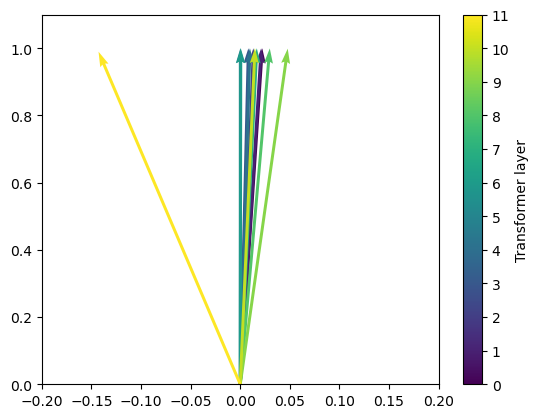

In [6]:
angles = np.arccos(cos_theta)
x = np.cos(angles)
y = np.sin(angles)

indices = np.arange(len(cos_theta))
colors = plt.cm.viridis(indices / indices.max())

fig, ax = plt.subplots()
ax.quiver(np.zeros_like(x), np.zeros_like(y), x, y, indices, cmap='viridis', scale=1, angles='xy', scale_units='xy')

ax.set_xlim(-0.2, 0.2)
ax.set_ylim(0, 1.1)

norm = mcolors.Normalize(vmin=0, vmax=len(cos_theta)-1)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Transformer layer')
cbar.set_ticks(np.arange(len(cos_theta)))
plt.show()

In [7]:
generator = GPT2LMHeadModel.from_pretrained("gpt2")
generator.eval()

generated_tokens = generator.generate(**inputs, max_length=50, pad_token_id=tokenizer.eos_token_id, temperature=0.9, do_sample=True)
generated_text = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
print("GENERATED TEXT:\n")
print(generated_text[0])

GENERATED TEXT:

The american flag is red, white and blue and many other colors. It has a big circle around the globe. When you take into consideration what other colors have been around, some people even claim that the american flag was once a symbol of


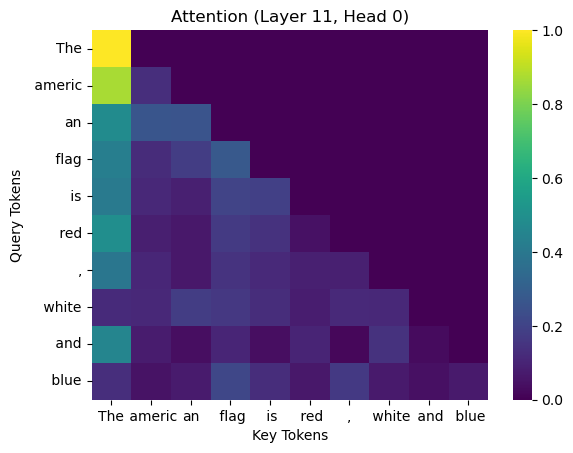

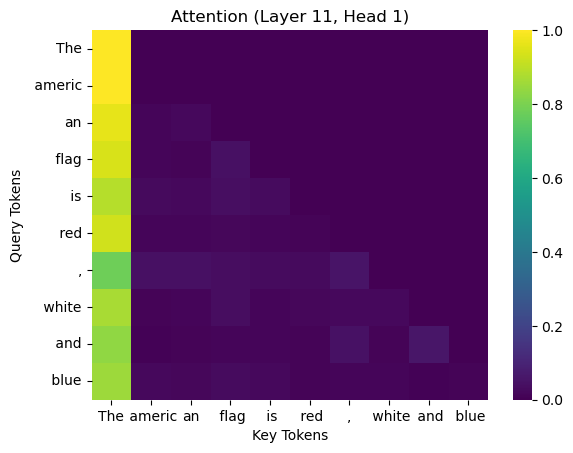

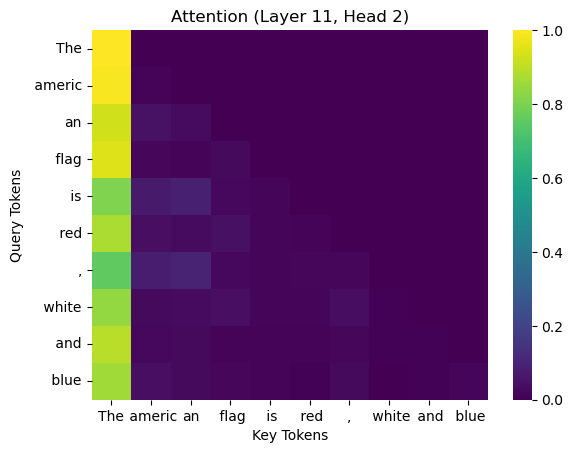

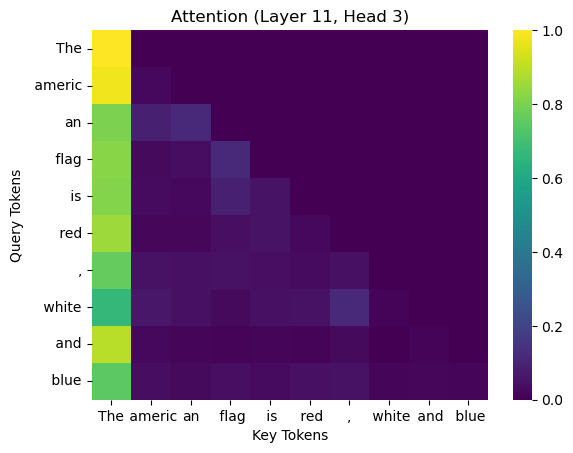

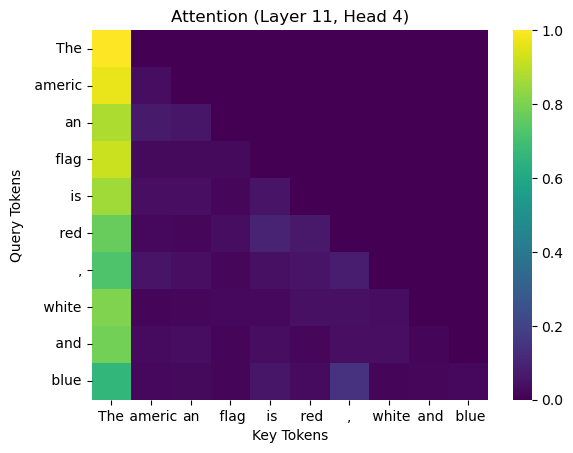

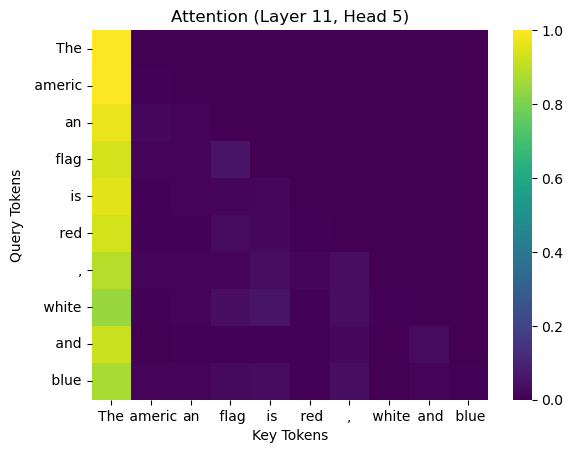

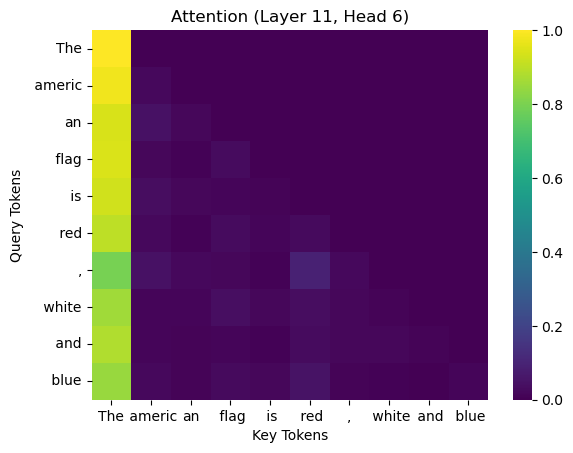

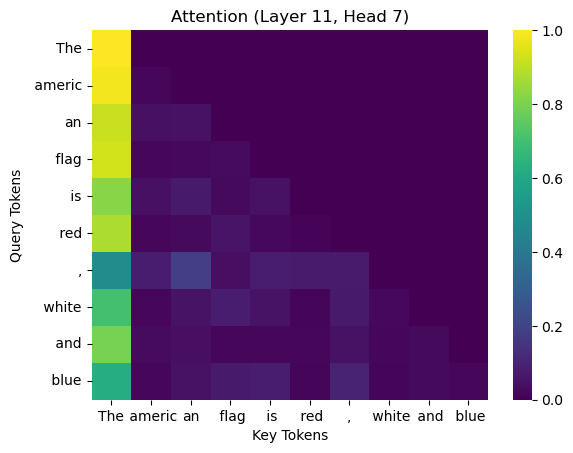

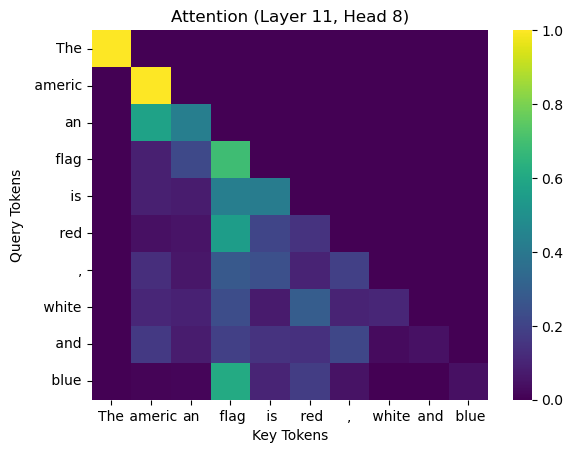

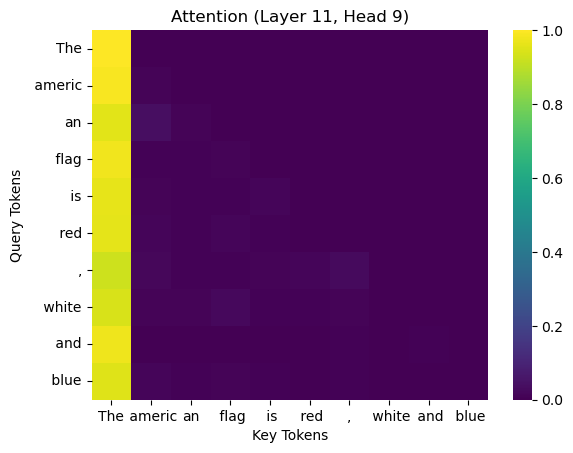

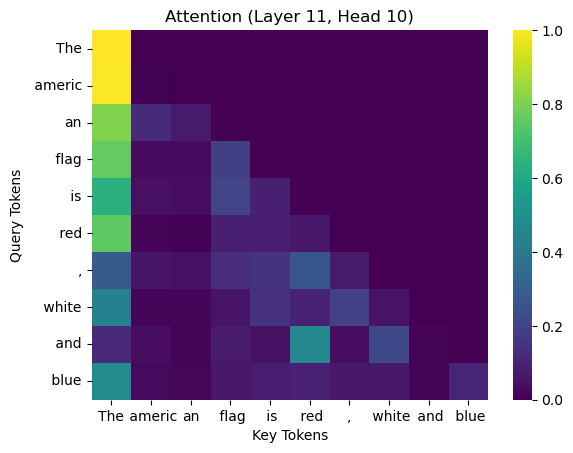

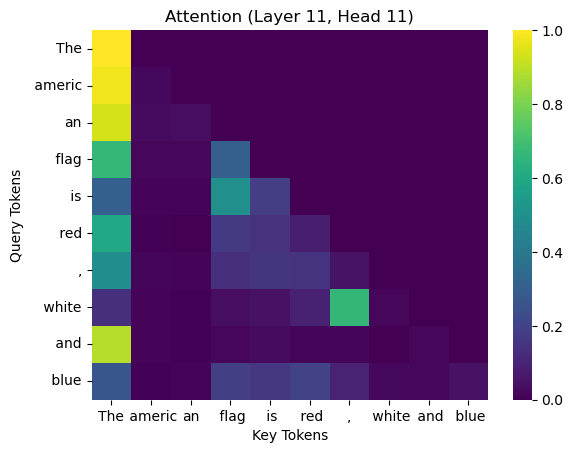

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

tokens = tokenizer.batch_decode(inputs['input_ids'][0])
for i in range(12):
    avg_attn = attentions[11][0, i]
    sns.heatmap(avg_attn.numpy(), xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Attention (Layer {11}, Head {i})")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()  


| Component | Name         | Shape          | Explanation                                                                                                 |
| --- |------------ | -------------- | ----------------------------------------------------------------------------------------------------------- |
| **Embedding** | `wte.weight` | `[50257, 768]` | **Token embeddings**: each token ID maps to a 768-dimensional vector. 50257 is the vocabulary size.         |
| | `wpe.weight` | `[1024, 768]`  | **Positional embeddings**: provides a learned embedding for each position (up to 1024 tokens per sequence). |
| **Transformer** |
| Norm | `h.N.ln_1.weight` | `[768]` | Learnable scale for **first layer norm** before attention. |
| | `h.N.ln_1.bias`   | `[768]` | Learnable bias for **first layer norm**.                   |
| Attention | `h.N.attn.c_attn.weight` | `[768, 2304]` | A **single matrix** for computing Q (query), K (key), and V (value) in **one fused linear layer**. <br>2304 = 3 × 768 (for Q, K, V). |
| | `h.N.attn.c_attn.bias`   | `[2304]`      | Bias for Q, K, V fused linear layer.                                                                                                 |
| | `h.N.attn.c_proj.weight` | `[768, 768]`  | Projection from concatenated heads back to the model dimension.                                                                      |
| | `h.N.attn.c_proj.bias`   | `[768]`       | Bias for attention output projection.                                                                                                |
| Norm | `h.N.ln_2.weight` | `[768]` | Learnable scale for **second layer norm** before MLP. |
| | `h.N.ln_2.bias`   | `[768]` | Learnable bias for **second layer norm**.             |
| FFNN | `h.N.mlp.c_fc.weight`   | `[768, 3072]` | First linear layer: expands dimensionality from 768 → 3072. |
| | `h.N.mlp.c_fc.bias`     | `[3072]`      | Bias for the first linear layer.                            |
| | `h.N.mlp.c_proj.weight` | `[3072, 768]` | Second linear layer: projects back 3072 → 768.              |
| | `h.N.mlp.c_proj.bias`   | `[768]`       | Bias for second linear layer.                               |
| **Final Norm** |
| | `ln_f.weight` | `[768]` | Scale parameter for **final layer norm**, applied after the last transformer block. |
| | `ln_f.bias`   | `[768]` | Bias for final layer norm.                                                          |







In [9]:
state_dict = model.state_dict() # dictionary with all the model parameters
WQ, WK, WV = state_dict['h.11.attn.c_attn.weight'].chunk(3, dim=1)
WO = state_dict['h.11.attn.c_proj.weight']
dQ, dK, dV = state_dict['h.11.attn.c_attn.bias'].chunk(3, dim=0)
dO = state_dict['h.11.attn.c_proj.bias']

$$Q = XW_Q+b_Q,\quad K=XW_K+b_K,\quad V=X W_V+b_V$$
$$A=\text{softmax}\left\{\frac{QK^T}{\sqrt{d_k}}\right\}$$
$$\text{Output}=(AV)W_O+b_O$$

For each head $i$ we have an attention matrix $A_i$ of size $N\times N$, than $AV$ is a $N\times 768$ block matrix where $(AV)_i$ corresponds to a single head $N\times64$ block. The output operation make a linear combination of these heads, using the weight matrix $W_O$ $768\times768$. This matrix can be seen as a block matrix $W_O^i$ for each head of dimension $64\times768$ plus a bias $64\times1$. Each matrix $W_O^i$ give an indication of how each head weights in the final $N\times 768$ matrix, so a norm-like quantity (Frobenius norm, spectral norm, max norm ...) indicate how much a specific head influence the final output.

In [121]:
blockWO = WO.chunk(12, dim=0)
blockbO = dO.chunk(12, dim=0)
head_weights = []
for i, block in enumerate(blockWO):
    norm_w = float(torch.norm(block, p='fro'))  # Frobenius norm
    norm_b = float(torch.norm(blockbO[i]))
    head_weights.append(norm_w + norm_b)

head_weights = 100*(head_weights/np.sum(head_weights))
print("Reltative Head weights:")
for i, w in enumerate(head_weights):
    print(f"Head {i:2}: {w:.1f} %")

# TODO: see if we can figure out what each attention head is doing

Reltative Head weights:
Head  0: 9.4 %
Head  1: 8.5 %
Head  2: 8.3 %
Head  3: 6.8 %
Head  4: 9.1 %
Head  5: 8.0 %
Head  6: 8.4 %
Head  7: 8.2 %
Head  8: 11.2 %
Head  9: 7.9 %
Head 10: 6.6 %
Head 11: 7.6 %
